In [1]:
import cv2
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


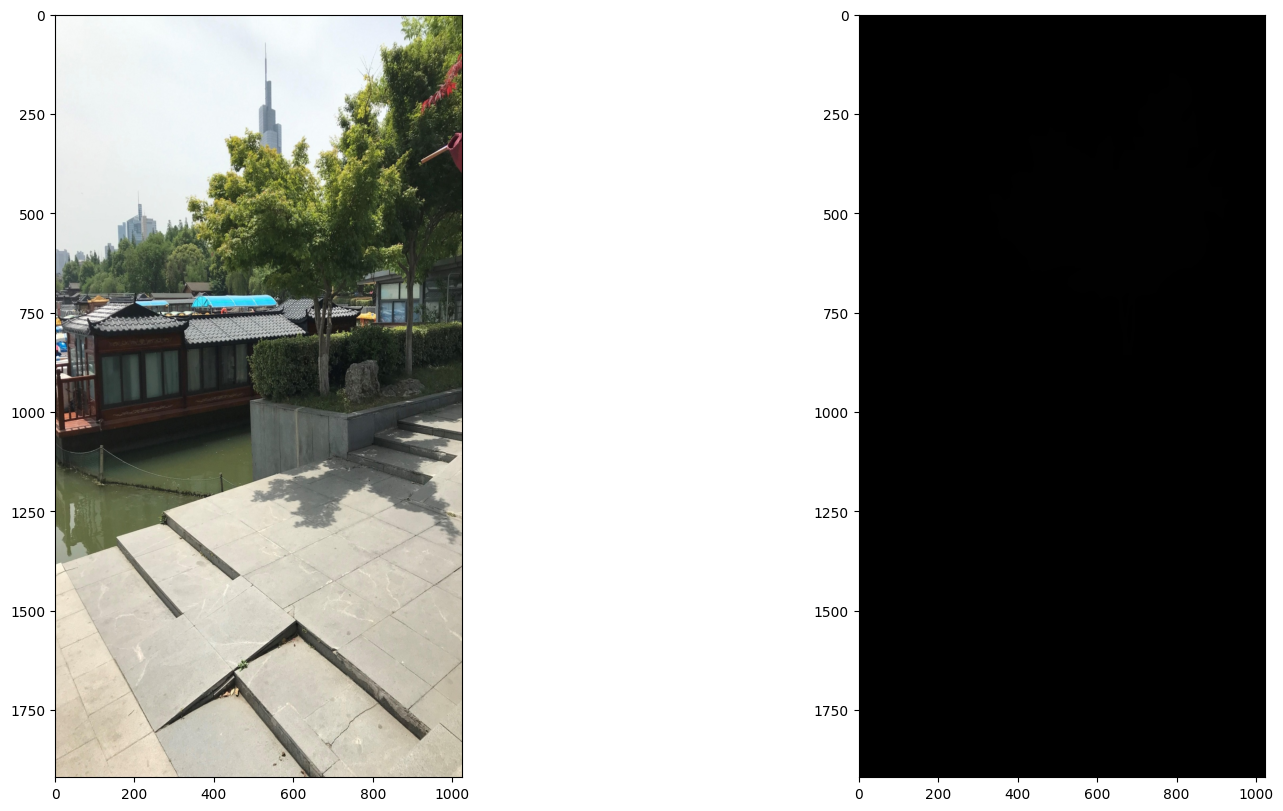

In [2]:
original_image = "/home/hamster02/courses/ugp_1/Motion_induction/tree/VOCdevkit/VOC2012/JPEGImages/Acer palmatum_tree_1 (1).jpg"
label_image_semantic = "/home/hamster02/courses/ugp_1/Motion_induction/tree/VOCdevkit/VOC2012/SegmentationClass/Acer palmatum_tree_1 (1).png"

# img.    
fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

original_image = Image.open(original_image)
axs[0].imshow(original_image)
axs[0].grid(False)
original_image = np.asarray(original_image)

label_image_semantic = Image.open(label_image_semantic)
axs[1].imshow(label_image_semantic)
axs[1].grid(False)
label_image_semantic = np.asarray(label_image_semantic)


(1920, 1024, 3)
(1920, 1024, 3)


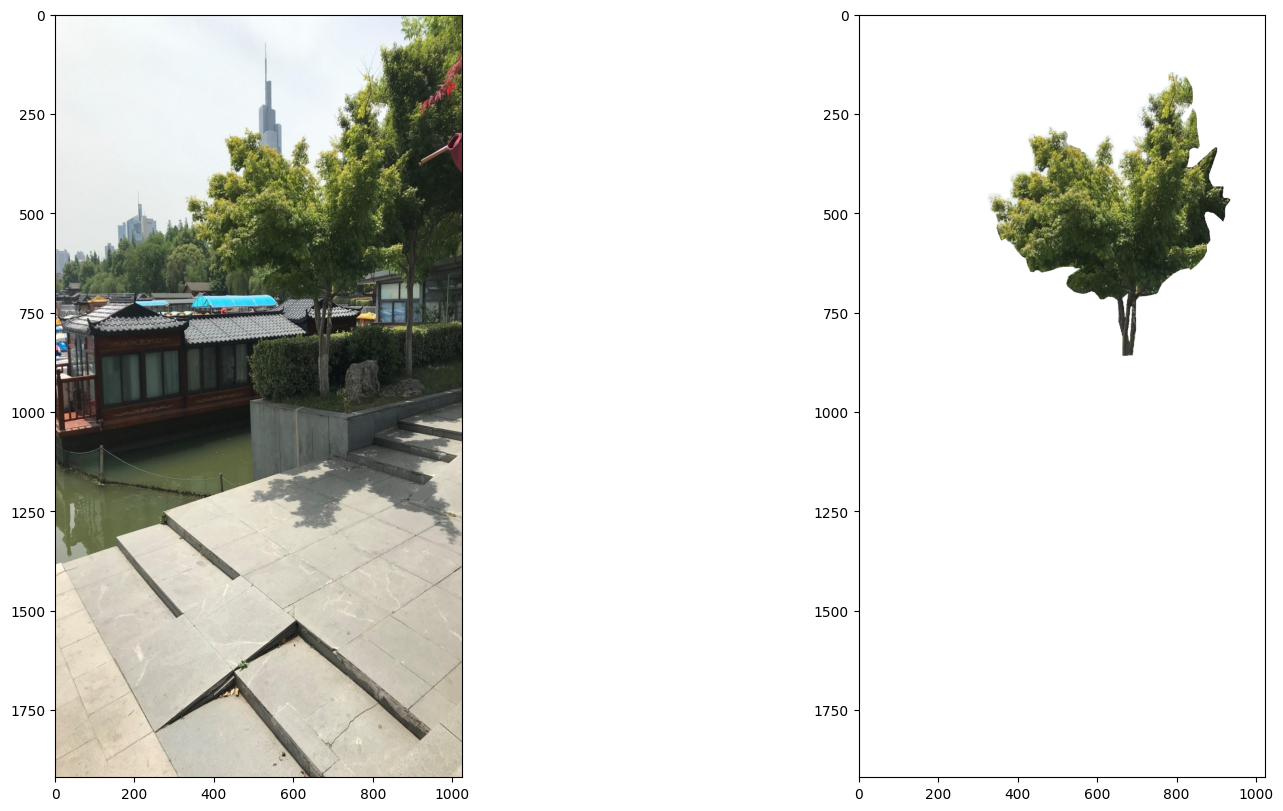

In [3]:
# black = np.array([0, 0, 0], dtype = "uint8")

#     # Find where all pixels are black in the first image
# black_pixels = np.all(label_image_semantic == black, axis=-1)

# print(label_image_semantic)
#     # Set those pixels to white in the second image
# original_image[black_pixels] = [1, 1, 1]
print(label_image_semantic.shape)
print(original_image.shape)

masked = label_image_semantic * original_image
lower_black = np.array([0, 0, 0], dtype = "uint8")
upper_black = np.array([0, 0, 0], dtype = "uint8")
# Create a mask that identifies all pixels that are in the range of black
black_mask = cv2.inRange(masked, lower_black, upper_black)
# Use the mask to change black pixels to white
masked[black_mask == 255] = [255, 255, 255]

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow(original_image)
axs[0].grid(False)

axs[1].imshow(masked)
axs[1].grid(False)
label_image_semantic = np.asarray(label_image_semantic)

In [47]:
def find_smallest_bounding_box(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold the image to extract non-white pixels
    _, thresholded = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

    # Initialize bounding box coordinates
    min_x = image.shape[1]
    max_x = 0
    min_y = image.shape[0]
    max_y = 0

    # Iterate through each pixel
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # Check if the pixel is non-white
            if thresholded[y, x] != 255:
                # Update bounding box coordinates
                min_x = min(min_x, x)
                max_x = max(max_x, x)
                min_y = min(min_y, y)
                max_y = max(max_y, y)

    # Calculate width and height of the bounding box
    width = max_x - min_x + 1
    height = max_y - min_y + 1

    return min_x, min_y, width, height

x, y, width, height = find_smallest_bounding_box(masked)

# Draw the bounding box on the masked
# cv2.rectangle(masked, (x, y), (x + width, y + height), (0, 255, 0), 2)

# Display the masked with the bounding box
cv2.imshow('Smallest Bounding Box', masked)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
def crop_and_save_region(image, x, y, width, height, output_filename):
    # Crop the region from the image
    cropped_region = image[y:y+height, x:x+width]
    
    # Save the cropped region with the new name
    cv2.imwrite(output_filename, cropped_region)

crop_and_save_region(masked, x, y, width, height, "../masked.jpg")

In [40]:
from PIL import Image, ImageSequence
import cv2
import numpy as np

def gif_to_opencv(gif_path):
    # Open the GIF file using Pillow
    gif = Image.open(gif_path)

    # Create a list to hold frames converted to OpenCV format
    frames = []

    # Loop over each frame in the animated GIF
    for frame in ImageSequence.Iterator(gif):
        # Convert the PIL image frame to a numpy array
        frame_cv = np.array(frame.convert('RGB'))  # Ensure RGB format

        # Convert RGB to BGR format for OpenCV
        frame_cv = frame_cv[:, :, ::-1]

        # Optionally, process the frame with OpenCV here
        # For example, display the frame
        cv2.imshow('Frame', frame_cv)
        cv2.waitKey(100)  # Wait 100 ms between frames

        # Append the OpenCV-compatible frame to the list (if needed for further processing)
        frames.append(frame_cv)

    cv2.destroyAllWindows()
    return frames

def overlay_image(background, overlay, top_left, bottom_right):
    """
    Overlay 'overlay' onto 'background' at the position specified by
    'top_left' and 'bottom_right' which define the rectangle bounds.
    Only non-white pixels from the overlay will be applied to the background.
    """
    # Calculate the size of the rectangle
    x, y = top_left
    w, h = bottom_right[0], bottom_right[1]

    # Resize the overlay image to the size of the rectangle
    overlay_resized = cv2.resize(overlay, (w, h))

    # Extract the region of interest (ROI) from the background where the overlay will be placed
    roi = background[y:y+h, x:x+w].copy()

    # Define a threshold to consider a pixel "white"
    white_threshold = 150
    # Find where all pixels are below the threshold
    non_white_mask = np.all(overlay_resized[:, :, :3] < white_threshold, axis=2)

    # Check if overlay has an alpha channel
    if overlay_resized.shape[2] == 4:
        # Get the alpha channel and adjust it with the non_white_mask
        alpha_overlay = overlay_resized[:, :, 3] / 255.0 * non_white_mask
        alpha_background = 1.0 - alpha_overlay
        
        # Blend the overlay with the background using the alpha channel
        for c in range(0, 3):
            roi[:, :, c] = (alpha_overlay * overlay_resized[:, :, c] +
                            alpha_background * roi[:, :, c])
    else:
        # For each color channel, apply the overlay only where non_white_mask is True
        for c in range(3):  # assuming BGR
            roi[non_white_mask, c] = overlay_resized[non_white_mask, c]
    out = background.copy()
    # Place the modified ROI back into the background image
    out[y:y+h, x:x+w] = roi

    return out

# Example usage
gif_path = '/home/hamster02/courses/ugp_1/image2video-synthesis-using-cINNs/assets/results/DTDB/vegetation/results.gif'
frames = gif_to_opencv(gif_path)
img = original_image
output_frame = overlay_image(img, frames[0], [x, y], [width, height])




In [41]:
cv2.imshow("frames", output_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [42]:
print(type(frames))

<class 'list'>


In [43]:
# img_frames = np.array(frames)
# print(img_frames.shape)
my_list = []
for frame in frames:
    my_list.append(overlay_image(original_image, frame, [x, y], [width, height]))

In [46]:
def frames_to_gif(frames, output_gif_path, duration=100):
    """
    Convert a list of image frames (NumPy arrays) into a GIF file.

    Parameters:
    - frames: List of image frames (NumPy arrays).
    - output_gif_path: Path where the GIF file will be saved.
    - duration: Duration (in milliseconds) for each frame in the GIF.
    """
    # Convert each frame to a PIL Image
    pil_frames = [Image.fromarray(frame) for frame in frames]

    # Save the frames as a GIF file
    pil_frames[0].save(output_gif_path, save_all=True, append_images=pil_frames[1:], optimize=False, duration=duration, loop=0)
    print("GIF saved:", output_gif_path)

# Example usage:
output_gif_path = 'output.gif'
duration = 100  # Duration (in milliseconds) for each frame in the GIF

# Assume 'processed_frames' is a list of NumPy arrays representing frames
# you can use the code where frames are being processed to fill this list.
frames_to_gif(my_list, output_gif_path, duration)

GIF saved: output.gif
